This scrip generates the structural counterfactuals (SCF) for the Law School data. To frame it as a (discrete) decision making process, we include an *admissions officer* based on [the "known" requirements of US Law Schools](https://schools.lawschoolnumbers.com/). 

We assume the case for Yale School. We could not find a one-to-one converter between LSAT over 48 to over 180. 173/180 is 96%; it would be abloud 46.1/48. Let's assume Yale cuts at these median values, and puts a slightly higher weight on UGPA over LSAT.

In [5]:
# Our decision makaer:
b1 = 0.6
b2 = 0.4
min_score = round(b1*3.93 + b2*46.1, 2)  # 20.8
max_score = round(b1*4.00 + b2*48.00)  # 22

In [ ]:
# data2['Score'] = b1*data2['UGPA'] + b2*data2['LSAT']
# data2['Y'] = np.where(data2['Score'] >= min_score, 1, 0)
# data2.head(5)

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scm_models.scm_law_school import LawSchool

In [7]:
# set relevant paths
wrk_dir = os.path.dirname(os.getcwd())
data_path = wrk_dir + '\\' + 'data' + '\\'
resu_path = wrk_dir + '\\' + 'results' + '\\'

### Pooled U
We focus on the same scenario as Kusner et al.: an unobserved confounder U (tbh, we could also not assume the confounder, but this way we show that, as long as we draw the confounder, we can proceed with cfST).

In [4]:
prefix = 'pU'  # meaning causal sufficiency is violated (Kusner et al.'s case)

# relevant vars list
vlist_protected = ['female', 'male', 'white', 'nonwhite']
vlist_latent = ['U']

df = pd.read_csv(resu_path + f'{prefix}_upd_LawData.csv', sep='|')
print(df.shape)
print(df.columns.tolist())

df.head(5)

(10896, 7)
['LSAT', 'UGPA', 'female', 'male', 'white', 'nonwhite', 'U']


,LSAT,UGPA,female,male,white,nonwhite,U
2,36,3.0,1,0,1,0,-0.736926
3,30,3.1,0,1,1,0,-0.267031
4,39,2.2,0,1,0,1,-1.647028
5,37,3.4,1,0,1,0,0.118742
6,30,3.6,1,0,1,0,0.502870


In [6]:
# the beta coefficients for the UGPA path(s)
ugpa_weights = pd.read_csv(resu_path + f'{prefix}_wUGPA_LawData.csv', sep='|')
ugpa_weights

,female,male,white,nonwhite,ugpa0,eta_u_ugpa
0,0.77306,0.640014,0.938756,0.713025,1.621285,0.350264


In [7]:
# the beta coefficients for the LSAT path(s)
lsat_weights = pd.read_csv(resu_path + f'{prefix}_wLSAT_LawData.csv', sep='|')
lsat_weights

,female,male,white,nonwhite,lsat0,eta_u_lsat
0,0.851098,0.867346,0.960812,0.823301,1.802908,0.032696


In [8]:
# check the diff files...
ugpa_deltas = pd.read_csv(resu_path + f'{prefix}_delta_ugpa.csv', sep='|')

(array([3.510e+02, 3.256e+03, 4.400e+03, 2.352e+03, 4.970e+02, 3.800e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.27671623, -0.16402471, -0.0513332 ,  0.06135832,  0.17404984,
         0.28674136,  0.39943288,  0.51212439,  0.62481591,  0.73750743,
         0.85019895]),
 <BarContainer object of 10 artists>)

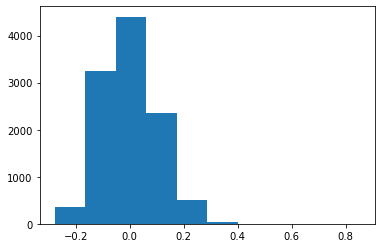

In [9]:
plt.hist(ugpa_deltas['delta'])

In [10]:
lsat_deltas = pd.read_csv(resu_path + f'{prefix}_delta_lsat.csv', sep='|')

(array([  39.,  460., 1536., 2877., 3077., 1958.,  711.,  190.,   43.,
           5.]),
 array([-15.75053364, -11.99623448,  -8.24193533,  -4.48763618,
         -0.73333702,   3.02096213,   6.77526129,  10.52956044,
         14.28385959,  18.03815875,  21.7924579 ]),
 <BarContainer object of 10 artists>)

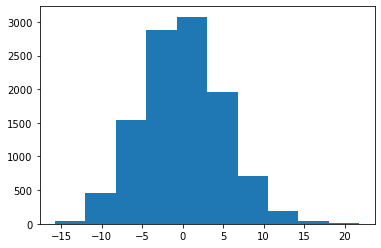

In [11]:
plt.hist(lsat_deltas['delta'])

### Define the DAG for the Law Schoold data: $\mathcal{G}$ is given

In [12]:
dag_law_school = [('U', 'UGPA', ugpa_weights.loc[0, 'eta_u_ugpa']),
                  ('U', 'LSAT', lsat_weights.loc[0, 'eta_u_lsat']),
                  ('female', 'UGPA', ugpa_weights.loc[0, 'female']),
                  ('male', 'UGPA', ugpa_weights.loc[0, 'male']),
                  ('white', 'UGPA', ugpa_weights.loc[0, 'white']),
                  ('nonwhite', 'UGPA', ugpa_weights.loc[0, 'nonwhite']),
                  ('female', 'LSAT', lsat_weights.loc[0, 'female']),
                  ('male', 'LSAT', lsat_weights.loc[0, 'male']),
                  ('white', 'LSAT', lsat_weights.loc[0, 'white']),
                  ('nonwhite', 'LSAT', lsat_weights.loc[0, 'nonwhite'])  
                 ]
dag_law_school

[('U', 'UGPA', 0.35026399476484804),
 ('U', 'LSAT', 0.0326959683105284),
 ('female', 'UGPA', 0.7730603366620609),
 ('male', 'UGPA', 0.6400142403982011),
 ('white', 'UGPA', 0.9387557544129591),
 ('nonwhite', 'UGPA', 0.7130248092744692),
 ('female', 'LSAT', 0.851097530659986),
 ('male', 'LSAT', 0.867345506707074),
 ('white', 'LSAT', 0.9608122538399481),
 ('nonwhite', 'LSAT', 0.823301257973325)]

In [13]:
# initiate the class LawSchool to get all the SCM methods (maybe too much for this...)
law_school = LawSchool(dag_law_school, 
                       end_vars=['UGPA', 'LSAT'], 
                       exo_vars=['U'], )

In [14]:
law_school.nodes

['U', 'UGPA', 'LSAT', 'female', 'male', 'white', 'nonwhite']

In [15]:
law_school.weights

{('U', 'UGPA'): 0.35026399476484804,
 ('U', 'LSAT'): 0.0326959683105284,
 ('female', 'UGPA'): 0.7730603366620609,
 ('male', 'UGPA'): 0.6400142403982011,
 ('white', 'UGPA'): 0.9387557544129591,
 ('nonwhite', 'UGPA'): 0.7130248092744692,
 ('female', 'LSAT'): 0.851097530659986,
 ('male', 'LSAT'): 0.867345506707074,
 ('white', 'LSAT'): 0.9608122538399481,
 ('nonwhite', 'LSAT'): 0.823301257973325}

In [16]:
law_school.adjacency_mtr

,U,UGPA,LSAT,female,male,white,nonwhite
U,0,0.350264,0.032696,0,0,0,0
UGPA,0,0.000000,0.000000,0,0,0,0
LSAT,0,0.000000,0.000000,0,0,0,0
female,0,0.773060,0.851098,0,0,0,0
male,0,0.640014,0.867346,0,0,0,0
white,0,0.938756,0.960812,0,0,0,0
nonwhite,0,0.713025,0.823301,0,0,0,0


In [17]:
law_school.adjacency_lst

{'U': ['UGPA', 'LSAT'],
 'UGPA': [],
 'LSAT': [],
 'female': ['UGPA', 'LSAT'],
 'male': ['UGPA', 'LSAT'],
 'white': ['UGPA', 'LSAT'],
 'nonwhite': ['UGPA', 'LSAT']}

### Define the SEM

In [18]:
# not an ideal solution... hard to scale this var-specific approacj tbh
law_school.define_sem()

introduce the structural equation model as a dict via 'SEM'
provide def_ugpa function for UGPA
provide def_lsat function for LSAT
provide each in the form: 'lambda row: df_var(row[x1],...,row[xj])'


In [19]:

# UGPA
def pred_ugpa(v_u, v_female, v_male, v_white, v_nonwhite):
    return (ugpa_weights.loc[0, 'ugpa0'] + 
            law_school.adjacency_mtr.loc['U']['UGPA'] * v_u +
            law_school.adjacency_mtr.loc['female']['UGPA'] * v_female +
            law_school.adjacency_mtr.loc['male']['UGPA'] * v_male +
            law_school.adjacency_mtr.loc['white']['UGPA'] * v_white +
            law_school.adjacency_mtr.loc['nonwhite']['UGPA'] * v_nonwhite)

# LSAT
def pred_lsat(v_u, v_female, v_male, v_white, v_nonwhite):
    return np.exp(lsat_weights.loc[0, 'lsat0'] + 
                  law_school.adjacency_mtr.loc['U']['LSAT'] * v_u +
                  law_school.adjacency_mtr.loc['female']['LSAT'] * v_female +
                  law_school.adjacency_mtr.loc['male']['LSAT'] * v_male +
                  law_school.adjacency_mtr.loc['white']['LSAT'] * v_white +
                  law_school.adjacency_mtr.loc['nonwhite']['LSAT'] * v_nonwhite)


In [20]:
law_school.SEM['UGPA'] = lambda row: pred_ugpa(
    v_u=row['U'], v_female=row['female'], v_male=row['male'], v_white=row['white'], v_nonwhite=row['nonwhite'])

law_school.SEM['LSAT'] = lambda row: pred_lsat(
    v_u=row['U'], v_female=row['female'], v_male=row['male'], v_white=row['white'], v_nonwhite=row['nonwhite'])

In [21]:
law_school.define_sem()

class instance already has a structural equation model dict; overwrite it via 'SEM' if needed


### Generate the factuals
i.e., run the SEM model... no need for our purposes 

In [22]:
test_df = law_school.run_sem(data=df)

generating FCTs in the following order:
UGPA
LSAT
generated the new variables:
fct_UGPA
fct_LSAT


In [25]:
test_df.head(5)

,LSAT,UGPA,female,male,white,nonwhite,U,fct_UGPA,fct_LSAT
2,36,3.0,1,0,1,0,-0.736926,3.074983,36.260282
3,30,3.1,0,1,1,0,-0.267031,3.106524,37.424839
4,39,2.2,0,1,0,1,-1.647028,2.397430,31.177707
5,37,3.4,1,0,1,0,0.118742,3.374692,37.289056
6,30,3.6,1,0,1,0,0.502870,3.509239,37.760340


### Generate the structural counterfactuals

Do so for gender and race...!

In [26]:
test_do = {'female': 0, 'male': 1} # everybody male!
test_do_desc = 'do_male'

In [27]:
do_male = law_school.generate_scfs(do=test_do, do_desc=test_do_desc, data=df)

do(female=0)
do(male=1)
generating SCFs in the following order:
UGPA
LSAT
generated the new variables:
scf_UGPA
scf_LSAT


In [28]:
do_male.head(5)

,LSAT,UGPA,female,male,white,nonwhite,U,org_female,org_male,scf_UGPA,scf_LSAT
2,36,3.0,0,1,1,0,-0.736926,1,0,2.941937,36.854251
3,30,3.1,0,1,1,0,-0.267031,0,1,3.106524,37.424839
4,39,2.2,0,1,0,1,-1.647028,0,1,2.397430,31.177707
5,37,3.4,0,1,1,0,0.118742,1,0,3.241646,37.899877
6,30,3.6,0,1,1,0,0.502870,1,0,3.376193,38.378880


In [29]:
test_do = {'nonwhite': 0, 'white': 1} # everybody white
test_do_desc = 'do_white'

In [30]:
do_white = law_school.generate_scfs(do=test_do, do_desc=test_do_desc, data=df)

do(nonwhite=0)
do(white=1)
generating SCFs in the following order:
UGPA
LSAT
generated the new variables:
scf_UGPA
scf_LSAT


In [31]:
do_white.head(5)

,LSAT,UGPA,female,male,white,nonwhite,U,org_nonwhite,org_white,scf_UGPA,scf_LSAT
2,36,3.0,1,0,1,0,-0.736926,0,1,3.074983,36.260282
3,30,3.1,0,1,1,0,-0.267031,0,1,3.106524,37.424839
4,39,2.2,0,1,1,0,-1.647028,1,0,2.623161,35.773747
5,37,3.4,1,0,1,0,0.118742,0,1,3.374692,37.289056
6,30,3.6,1,0,1,0,0.502870,0,1,3.509239,37.760340


In [ ]:
# we need to add a decision outcome: say, to enter Harvard (go to that website)

In [33]:
# store both datasets for cfST
do_male.to_csv(resu_path + '\\counterfactuals\\' + 'cf_male_LawSchoolData.csv', sep='|', index=False)
do_white.to_csv(resu_path + '\\counterfactuals\\' + 'cf_white_LawSchoolData.csv', sep='|', index=False)